# Flow Meter Data Processing Script #

This script takes as input a csv file from the Alicat Flow Meter Device. Users must edit the .txt file and remove the infinity sign in the temperature column in the file so that the code can properly run. Remove the random signal in the temperature column so that the code below can run.

## Load Data from Flow Meter ##

In [205]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('Alicat Data Log_05-16-2019_15-21-10_PM JAJ part 2.txt', header=None)
df.columns = ["Time Stamp", "Absolute Pressure [PSIA]", "Temperature", "Volumetric [mL/s]", "Mass Flow [SCCM]","Gas Selected"]
df.drop(df.index[0], inplace=True)
df.index = np.arange(0, len(df))
data = df

In [208]:
data.head()

,Time Stamp,Absolute Pressure [PSIA],Temperature,Volumetric [mL/s],Mass Flow [SCCM],Gas Selected
0,15:21:10.750,14.760000,25.410000,0.000000,0.000000,N2
1,15:21:10.783,14.760000,25.410000,0.000000,0.000000,N2
2,15:21:10.813,14.760000,25.410000,0.000000,0.000000,N2
3,15:21:10.846,14.760000,25.410000,0.000000,0.000000,N2
4,15:21:10.879,14.760000,25.410000,0.000000,0.000000,N2


In [209]:
data.dtypes


Time Stamp                  object
Absolute Pressure [PSIA]    object
Temperature                 object
Volumetric [mL/s]           object
Mass Flow [SCCM]            object
Gas Selected                object
dtype: object

In [169]:
data['Time Stamp'].head()

0    15:21:10.750
1    15:21:10.783
2    15:21:10.813
3    15:21:10.846
4    15:21:10.879
Name: Time Stamp, dtype: object

In [170]:
data.columns

Index(['Time Stamp', 'Absolute Pressure [PSIA]', 'Temperature',
       'Volumetric [mL/s]', 'Mass Flow [SCCM]', 'Gas Selected'],
      dtype='object')

In [214]:
data["Absolute Pressure [PSIA]"] = pd.to_numeric(data["Absolute Pressure [PSIA]"])
data["Temperature"] = pd.to_numeric(data["Temperature"])
data["Volumetric [mL/s]"] = pd.to_numeric(data["Volumetric [mL/s]"])
data["Mass Flow [SCCM]"] = pd.to_numeric(data["Mass Flow [SCCM]"])



# Graph Data - Without Preprocessing #

## Pressure Data ##

In [215]:
data['Absolute Pressure [PSIA]'].index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            48063, 48064, 48065, 48066, 48067, 48068, 48069, 48070, 48071,
            48072],
           dtype='int64', length=48073)

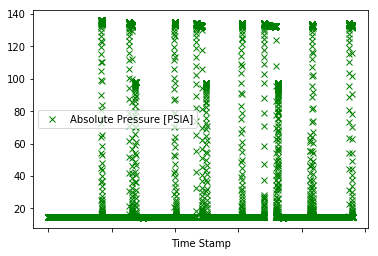

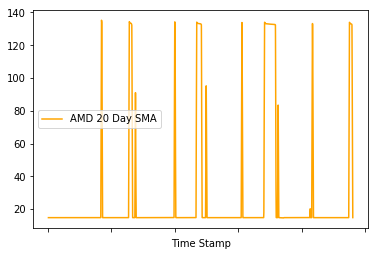

In [218]:
%matplotlib inline

avg_win = 100

P_max = data['Absolute Pressure [PSIA]'].max()
P_min = data['Absolute Pressure [PSIA]'].min()
P_std = data['Absolute Pressure [PSIA]'].std()
data['rolling_mean_p'] = data['Absolute Pressure [PSIA]'].rolling(window=avg_win).mean()


plt = data.plot(x='Time Stamp', y='Absolute Pressure [PSIA]', style=['gx','r.'])
plt2 = data.plot(x='Time Stamp', y='rolling_mean_p', label='AMD 20 Day SMA', color='orange')

#fig1 = plt.get_figure()
#fig1.savefig("output1.png")

## Temperature Data ##

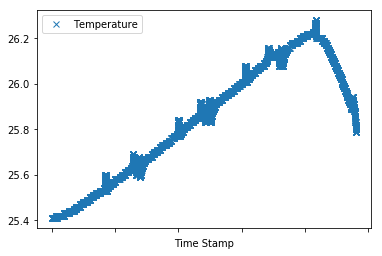

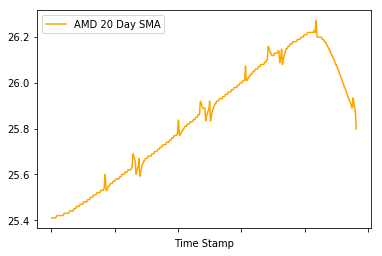

In [220]:
%matplotlib inline

T_max = data['Temperature'].max()
T_min = data['Temperature'].min()
T_std = data['Temperature'].std()

data['rolling_mean_t'] = data['Temperature'].rolling(window=avg_win).mean()

plt = data.plot(x='Time Stamp', y='Temperature', style=['x','r.'])

plt2 = data.plot(x='Time Stamp', y='rolling_mean_t', label='AMD 20 Day SMA', color='orange')


#plt.savefig('pie')
#fig2 = plt.get_figure()
#fig2.savefig("output2.png")

In [221]:
data.columns

Index(['Time Stamp', 'Absolute Pressure [PSIA]', 'Temperature',
       'Volumetric [mL/s]', 'Mass Flow [SCCM]', 'Gas Selected',
       'rolling_mean_p', 'rolling_mean_t'],
      dtype='object')

## Mass Flow [SCCM] ##

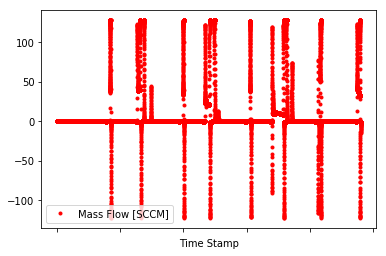

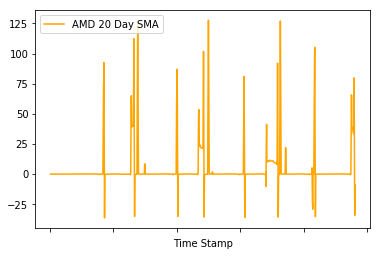

In [223]:
mass_flow_max = data['Mass Flow [SCCM]'].max()
mass_flow_min = data['Mass Flow [SCCM]'].min()
mass_flow_std = data['Mass Flow [SCCM]'].std()

data['rolling_mean_mf'] = data['Mass Flow [SCCM]'].rolling(window=avg_win).mean()

plt = data.plot(x='Time Stamp', y='Mass Flow [SCCM]', style=['r.'])
plt2 = data.plot(x='Time Stamp', y='rolling_mean_mf', label='AMD 20 Day SMA', color='orange')

fig3 = plt.get_figure()
#fig3.savefig("output3.png")

## Volumetric Flow [ml/s] ##

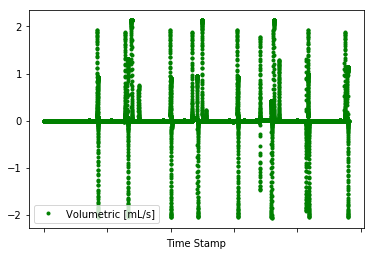

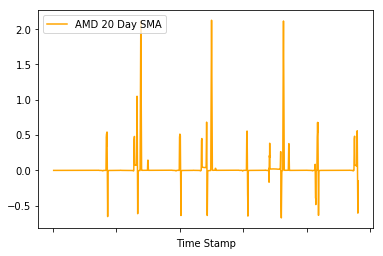

In [224]:
vol_flow_max = data['Volumetric [mL/s]'].max()
vol_flow_min = data['Volumetric [mL/s]'].min()
vol_flow_std = data['Volumetric [mL/s]'].std()

data['rolling_mean_vf'] = data['Volumetric [mL/s]'].rolling(window=avg_win).mean()

plt = data.plot(x='Time Stamp', y='Volumetric [mL/s]', style=['g.'])
plt2 = data.plot(x='Time Stamp', y='rolling_mean_vf', label='AMD 20 Day SMA', color='orange')

fig4 = plt.get_figure()
#fig4.savefig("output4.png")

# Get Maximum Readings #

In [225]:
T_max

26.280000000000001

In [226]:
vol_flow_max #mL/s

2.133

In [227]:
mass_flow_max #SCCM

128.0

In [228]:
P_max #PSIA

136.09

## Separate Peaks ##

### Prepare time data ###

In [229]:
import numpy as np
data['Time Stamp'].head(5)

time_arr = np.array(data['Time Stamp'])
time_arr

array(['15:21:10.750', '15:21:10.783', '15:21:10.813', ..., '15:47:09.344',
       '15:47:09.375', '15:47:09.407'], dtype=object)

### Build Helper Function to Convert String into Time ##

In [245]:
def convert_str_t(str_time, units = 'milliseconds'):
    
## '20:20:00.00'

    hours = float(str_time[0:2])
    #print(hours)
    minutes = float(str_time[3:5])
    #print(minutes)
    seconds = float(str_time[6:])
    #print(seconds)
    
    if units == 'seconds':
        total_seconds = (hours * 60 * 60 + minutes * 60 + seconds)
        return total_seconds
    
    elif units == 'milliseconds':
        total_milliseconds = (hours * 60 * 60 + minutes * 60 + seconds)*1000
        return total_milliseconds
    
    elif units == 'hours':
        total_hours = hours + minutes/60.0 + seconds/(60.0*60.0)
        
        return total_hours

##Debug test cases
total_time = convert_str_t('15:21:12.1234', 'milliseconds') 
diff_time = convert_str_t('21:12.45787', 'milliseconds') - convert_str_t('21:12.34567', 'milliseconds') #resolut
diff_time

11220000.0

In [246]:
import numpy as np
press_arr = np.array(data['rolling_mean_p'])
massflow_arr = np.array(data['rolling_mean_mf'])
volflow_arr = np.array(data['rolling_mean_vf'])
temp_arr = np.array(data['rolling_mean_t'])

time_arr = np.array(data['Time Stamp'])
len(press_arr)

48073

### Build time array starting at t=0 ###

In [254]:
time_arr_s = []
time = [] #formatted time starting from t=0
for idx, ele in enumerate(time_arr):
    time_arr_s.append(convert_str_t(ele, 'hours'))
    
for idx, ele in enumerate(time_arr_s):
    time.append(time_arr_s[idx] - time_arr_s[0])

time = np.array(time)

In [255]:
time

array([  0.00000000e+00,   9.16666667e-06,   1.75000000e-05, ...,
         4.32942778e-01,   4.32951389e-01,   4.32960278e-01])

In [256]:
press_arr

array([     nan,      nan,      nan, ...,  14.7865,  14.7829,  14.78  ])

In [257]:
len(time_arr_s)

48073

## Subplots of Averaged Data ## 

<function matplotlib.pyplot.show>

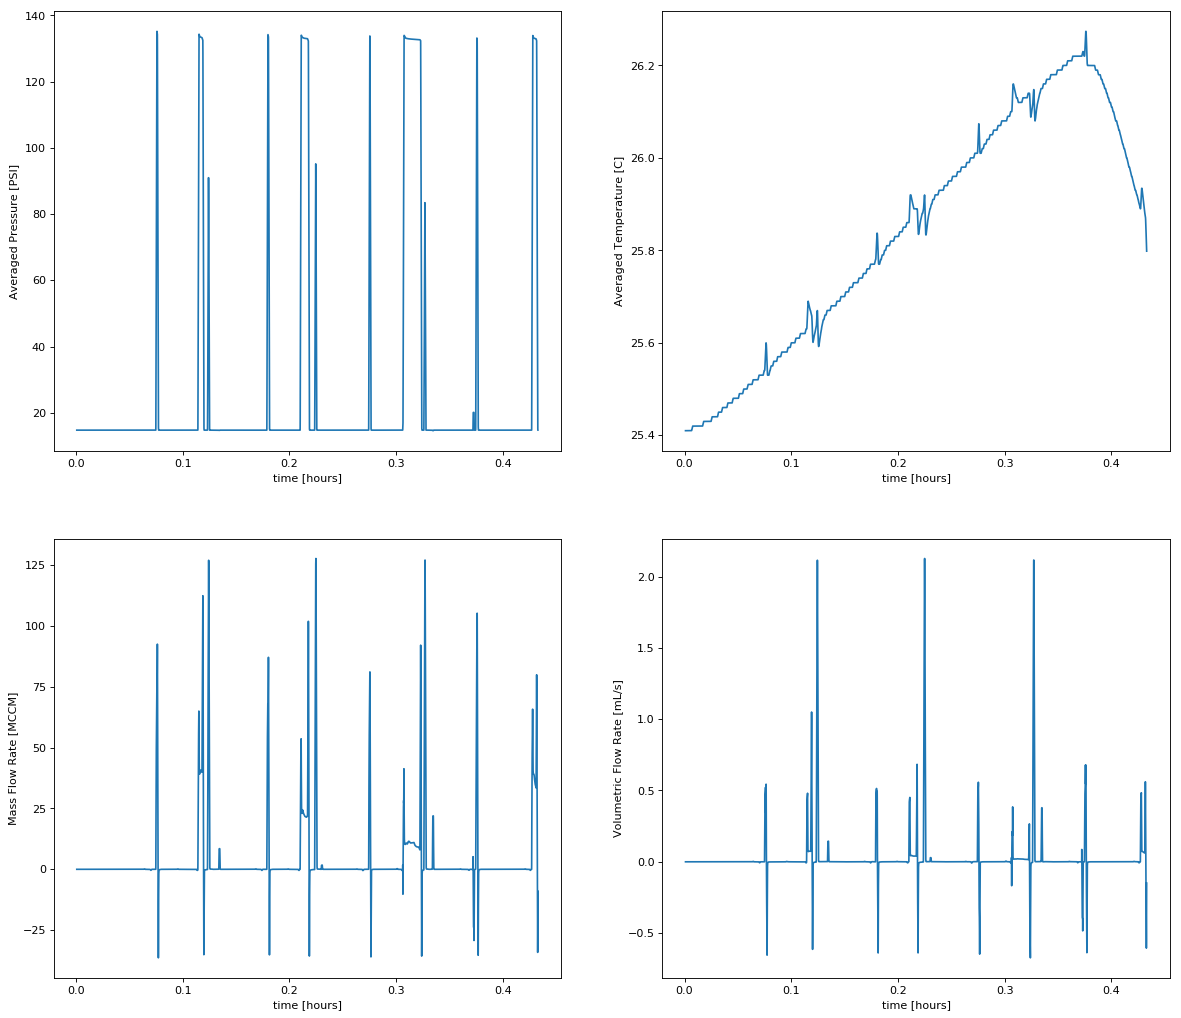

In [260]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

#plt.plot(time, press_arr)
plt.subplot(2, 2, 1)
plt.plot(time, press_arr)
plt.xlabel('time [hours]')
plt.ylabel('Averaged Pressure [PSI]')

plt.subplot(2, 2, 2)
plt.plot(time, temp_arr)
plt.xlabel('time [hours]')
plt.ylabel('Averaged Temperature [C]')

plt.subplot(2, 2, 3)
plt.plot(time, massflow_arr)
plt.xlabel('time [hours]')
plt.ylabel('Mass Flow Rate [MCCM]')

plt.subplot(2, 2, 4)
plt.plot(time, volflow_arr)
plt.xlabel('time [hours]')
plt.ylabel('Volumetric Flow Rate [mL/s]')

plt.show

### Peak Analysis Logic ###

1. Scan array & identify peaks left-to-right
2. Identify start and end indices of peak detected
3. Build new peak array
4. Dynamically plot peaks based on N peaks
5. Calculate numbers (max pressure & graph on the plot, duration of peak


In [261]:
def remove_nans(p):
    '''Function that removes nan values from array data'''
    if len(p) > 0:
        p = p[np.logical_not(np.isnan(p))]
    return p

In [262]:
len(press_arr)

48073

In [263]:
press_arr = remove_nans(press_arr)
pd.DataFrame(press_arr[8000:9000])

,0
0,14.7556
1,14.7556
2,14.7556
3,14.7556
4,14.7555
5,14.7555
6,14.7556
7,14.7557
8,14.7556
9,14.7555


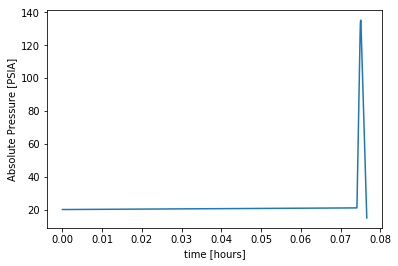

In [269]:
def find_pressure_peak(p, t, p_threshold):
    '''Finds the first peak in a series of pressure peaks in a time series dataset of flow meter data of uVS chips 
       during transfection experiments and returns an array of all the elements in that peak''' 
    t = list(t) #convert to list to perform operations on it
    t_stamp = []
    pk = []
    p = [round(x,1) for x in p]
    first_idx = 0
    last_idx = 0 
    
    for i, ele in enumerate(list(p)):
        if i % 10 == 0:
            diff = p[i] - p[i-1]
            diff2 = p[i] - p_threshold
            #print(i, diff, diff2)
            
        if  diff2 > 2.0 and diff >= 0.1:
            pk.append(ele)
            t_stamp.append(time[i]) 
            first_idx = t_stamp[0]
            #print(t_stamp)
            
        if diff < 0.0 and diff2 > .1 and diff2 < 1.0:
            pk.append(ele)
            t_stamp.append(time[i])
            last_idx = i
            #print(t_stamp)
            break 
            
    #Make time start from t=0 for the peak identified
    for j, ele in enumerate(t_stamp):
        t_stamp[j] = t_stamp[j] - t_stamp[0]
    
    return pk, t_stamp, first_idx, last_idx
    
press_arr = remove_nans(press_arr)
pk, t_stamp, first_idx, last_idx = find_pressure_peak(press_arr, time, 14.7)
plt.xlabel('time [hours]')
plt.ylabel('Absolute Pressure [PSIA]')

plt.plot(t_stamp, pk)



In [267]:
len(time)

48073

## Building Processing Script ##

0 0.0 0.1
10 0.0 0.1
20 0.0 0.1
30 0.0 0.1
40 0.0 0.1
50 0.0 0.1
60 0.0 0.1
70 0.0 0.1
80 0.0 0.1
90 0.0 0.1
100 0.0 0.1
110 0.0 0.1
120 0.0 0.1
130 0.0 0.1
140 0.0 0.1
150 0.0 0.1
160 0.0 0.1
170 0.0 0.1
180 0.0 0.1
190 0.0 0.1
200 0.0 0.1
210 0.0 0.1
220 0.0 0.1
230 0.0 0.1
240 0.0 0.1
250 0.0 0.1
260 0.0 0.1
270 0.0 0.1
280 0.0 0.1
290 0.0 0.1
300 0.0 0.1
310 0.0 0.1
320 0.0 0.1
330 0.0 0.1
340 0.0 0.1
350 0.0 0.1
360 0.0 0.1
370 0.0 0.1
380 0.0 0.1
390 0.0 0.1
400 0.0 0.1
410 0.0 0.1
420 0.0 0.1
430 0.0 0.1
440 0.0 0.1
450 0.0 0.1
460 0.0 0.1
470 0.0 0.1
480 0.0 0.1
490 0.0 0.1
500 0.0 0.1
510 0.0 0.1
520 0.0 0.1
530 0.0 0.1
540 0.0 0.1
550 0.0 0.1
560 0.0 0.1
570 0.0 0.1
580 0.0 0.1
590 0.0 0.1
600 0.0 0.1
610 0.0 0.1
620 0.0 0.1
630 0.0 0.1
640 0.0 0.1
650 0.0 0.1
660 0.0 0.1
670 0.0 0.1
680 0.0 0.1
690 0.0 0.1
700 0.0 0.1
710 0.0 0.1
720 0.0 0.1
730 0.0 0.1
740 0.0 0.1
750 0.0 0.1
760 0.0 0.1
770 0.0 0.1
780 0.0 0.1
790 0.0 0.1
800 0.0 0.1
810 0.0 0.1
820 0.0 0.1
830 0.0 0.1
840

1450 0.0 0.1
1460 0.0 0.1
1470 0.0 0.1
1480 0.0 0.1
1490 0.0 0.1
1500 0.0 0.1
1510 0.0 0.1
1520 0.0 0.1
1530 0.0 0.1
1540 0.0 0.1
1550 0.0 0.1
1560 0.0 0.1
1570 0.0 0.1
1580 0.0 0.1
1590 0.0 0.1
1600 0.0 0.1
1610 0.0 0.1
1620 0.0 0.1
1630 0.0 0.1
1640 0.0 0.1
1650 0.0 0.1
1660 0.0 0.1
1670 0.0 0.1
1680 0.0 0.1
1690 0.0 0.1
1700 0.0 0.1
1710 0.0 0.1
1720 0.0 0.1
1730 0.0 0.1
1740 0.0 0.1
1750 0.0 0.1
1760 0.0 0.1
1770 0.0 0.1
1780 0.0 0.1
1790 0.0 0.1
1800 0.0 0.1
1810 0.0 0.1
1820 0.0 0.1
1830 0.0 0.1
1840 0.0 0.1
1850 0.0 0.1
1860 0.0 0.1
1870 0.0 0.1
1880 0.0 0.1
1890 0.0 0.1
1900 0.0 0.1
1910 0.0 0.1
1920 0.0 0.1
1930 0.0 0.1
1940 0.0 0.1
1950 0.0 0.1
1960 0.0 0.1
1970 0.0 0.1
1980 0.0 0.1
1990 0.0 0.1
2000 0.0 0.1
2010 0.0 0.1
2020 0.0 0.1
2030 0.0 0.1
2040 0.0 0.1
2050 0.0 0.1
2060 0.0 0.1
2070 0.0 0.1
2080 0.0 0.1
2090 0.0 0.1
2100 0.0 0.1
2110 0.0 0.1
2120 0.0 0.1
2130 0.0 0.1
2140 0.0 0.1
2150 0.0 0.1
2160 0.0 0.1
2170 0.0 0.1
2180 0.0 0.1
2190 0.0 0.1
2200 0.0 0.1
2210 0.0 0.1

110 0.0 0.1
120 0.0 0.1
130 0.0 0.1
140 0.0 0.1
150 0.0 0.1
160 0.0 0.1
170 0.0 0.1
180 0.0 0.1
190 0.0 0.1
200 0.0 0.1
210 0.0 0.1
220 0.0 0.1
230 0.0 0.1
240 0.0 0.1
250 0.0 0.1
260 0.0 0.1
270 0.0 0.1
280 0.0 0.1
290 0.0 0.0
300 0.0 0.0
310 0.0 -0.1
320 0.0 -0.1
330 0.0 -0.1
340 0.0 -0.1
350 0.0 -0.1
360 0.0 -0.1
370 0.0 -0.1
380 0.0 -0.1
390 0.0 -0.1
400 0.0 0.0
410 0.0 0.0
420 0.0 0.1
430 0.0 0.1
440 0.0 0.1
450 0.0 0.1
460 0.0 0.1
470 0.0 0.1
480 0.0 0.1
490 0.0 0.1
500 0.0 0.1
510 0.0 0.1
520 0.0 0.1
530 0.0 0.1
540 0.0 0.1
550 0.0 0.1
560 0.0 0.1
570 0.0 0.1
580 0.0 0.1
590 0.0 0.1
600 0.0 0.1
610 0.0 0.1
620 0.0 0.1
630 0.0 0.1
640 0.0 0.1
650 0.0 0.1
660 0.0 0.1
670 0.0 0.1
680 0.0 0.1
690 0.0 0.1
700 0.0 0.1
710 0.0 0.1
720 0.0 0.1
730 0.0 0.1
740 0.0 0.1
750 0.0 0.1
760 0.0 0.1
770 0.0 0.1
780 0.0 0.1
790 0.0 0.1
800 0.0 0.1
810 0.0 0.1
820 0.0 0.1
830 0.0 0.1
840 0.0 0.1
850 0.0 0.1
860 0.0 0.1
870 0.0 0.1
880 0.0 0.1
890 0.0 0.1
900 0.0 0.1
910 0.0 0.1
920 0.0 0.1
930 0.0

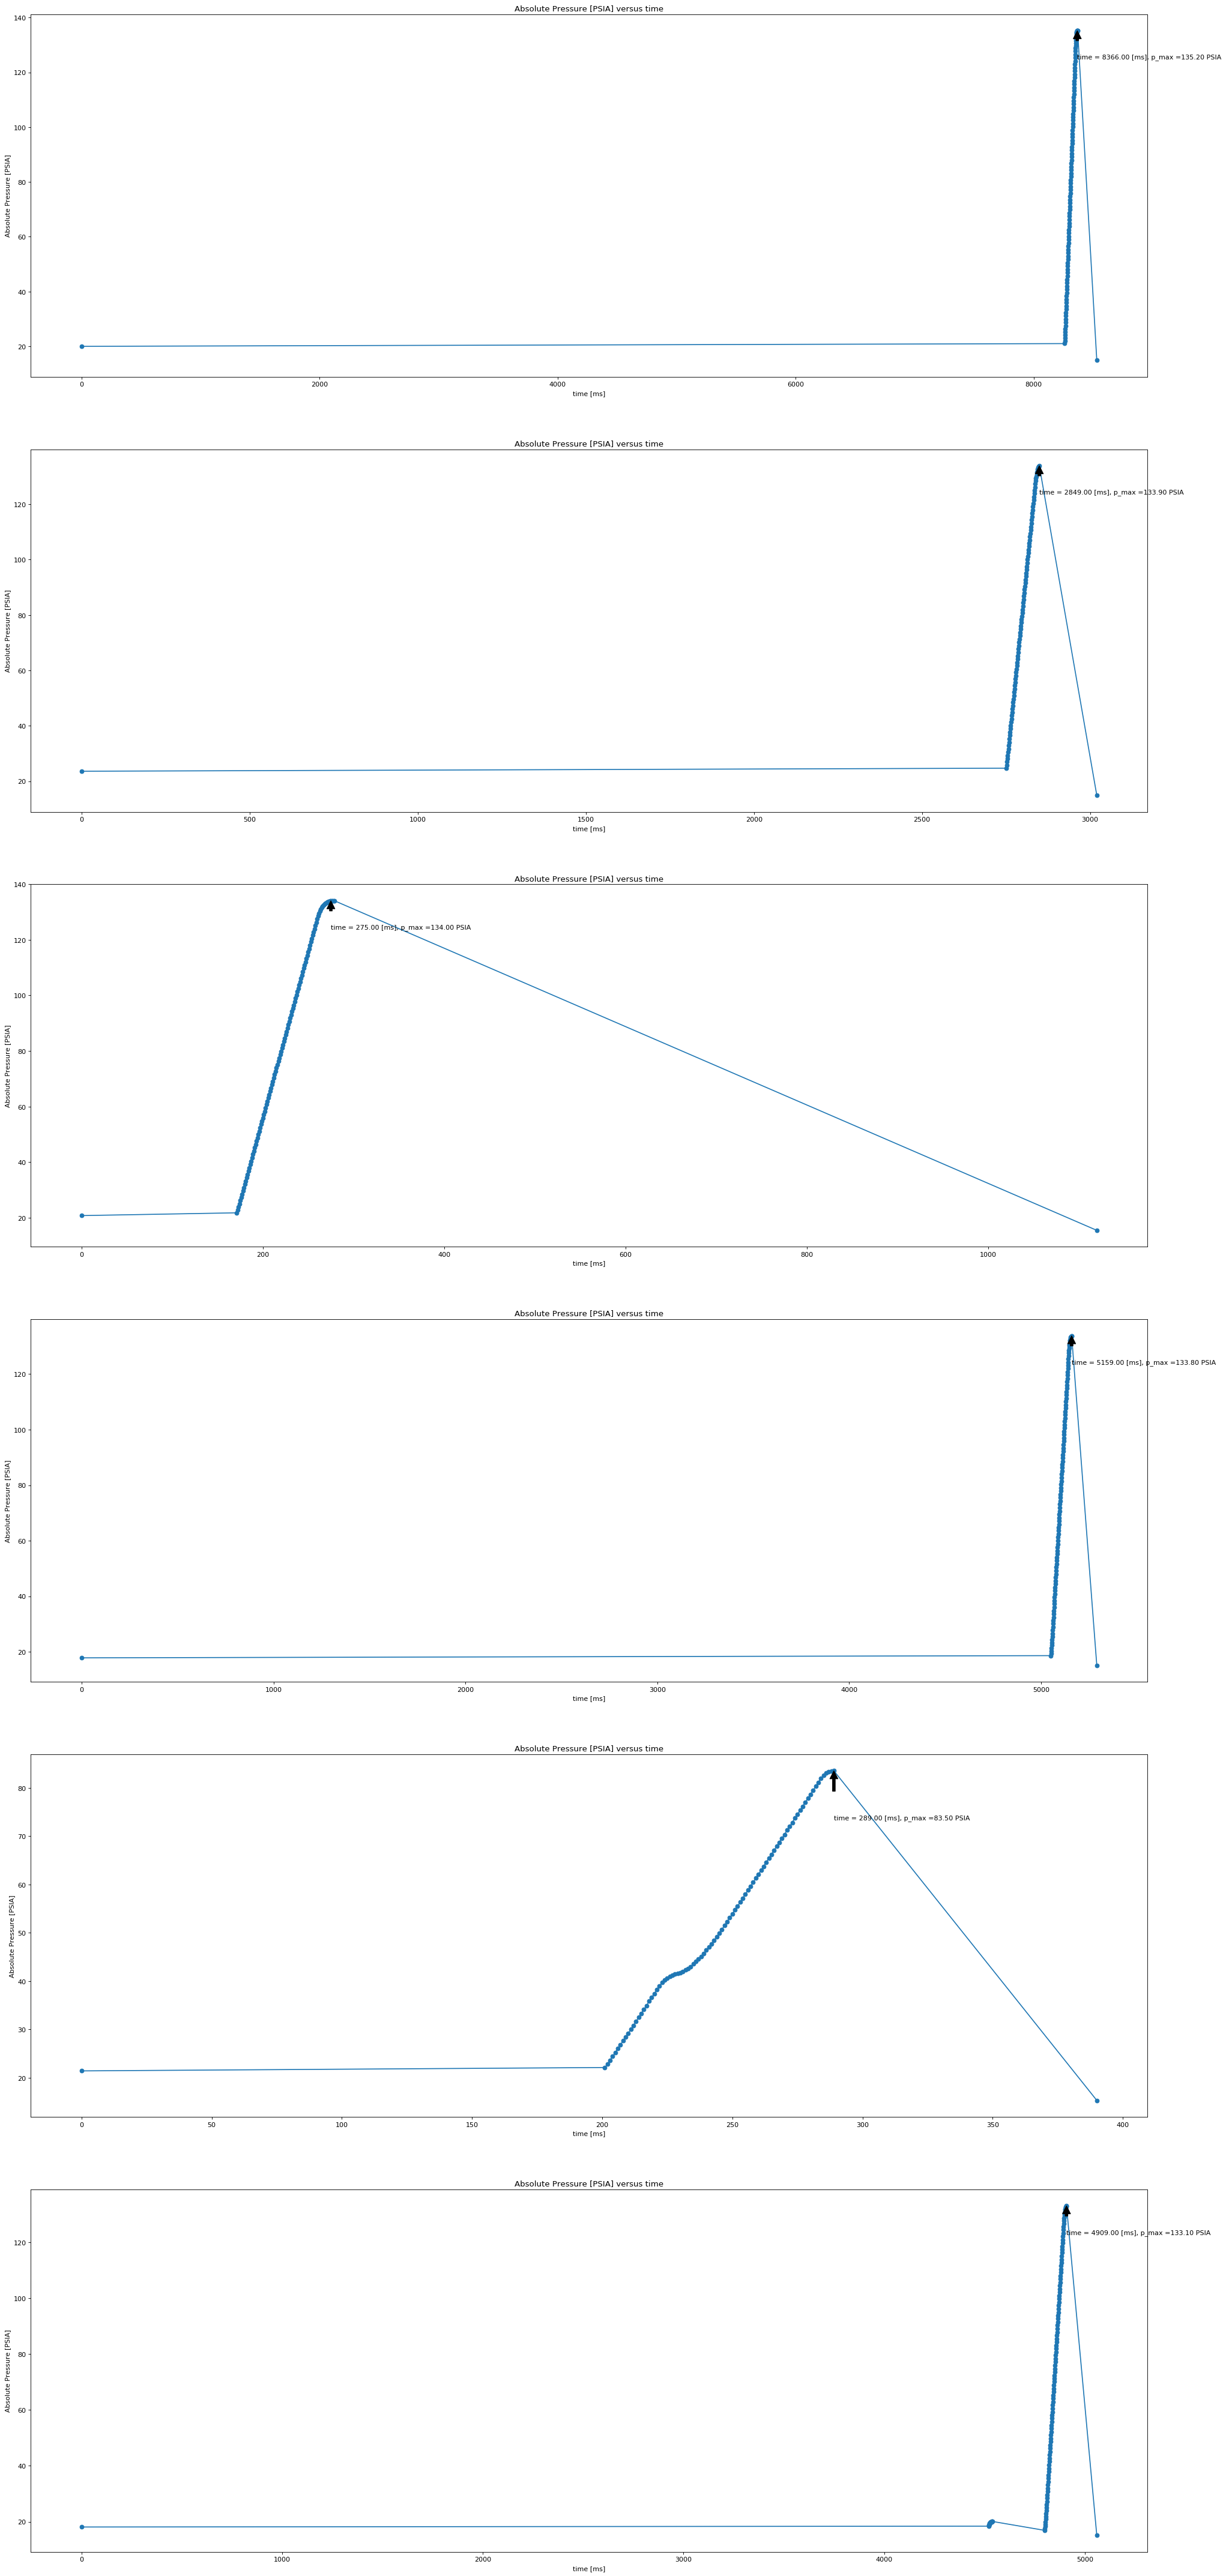

In [35]:
from collections import deque
fig=plt.figure(figsize=(30, 70), dpi= 80, facecolor='w', edgecolor='k')

press_arr = np.array(data['rolling_mean_p'])
press_arr = remove_nans(press_arr)

temp = []
temp_time = []
num_peaks = 8 ##write a function to calculate peaks

for i in range(num_peaks):    
    if len(press_arr) > 0: 
        press_arr = press_arr[last_idx:]
        pk, t_stamp, first_idx, last_idx = find_pressure_peak(press_arr, time, p_threshold=14.7)
        
        if last_idx != 0:
            #print(last_idx)
            press_arr = press_arr[last_idx:]
            temp.append(pk)
            temp_time.append(t_stamp)
        #press_arr = clear_elements(press_arr[last_idx:, len(pk))
        #pk = clear_elements(pk, len(pk))
        #print(last_idx) #THE INDEX IS CHANGING EVERYTHING YOU INDEX FROM PRESS_ARR again. substract by starting time po
        ##THE INDEX IS CHANGING EVERYTHING YOU INDEX FROM PRESS_ARR again. substract by starting time point

for j in range(len(temp)):
    plt.subplot(len(temp), 1, j+1)
    plt.title('Absolute Pressure [PSIA] versus time')
    plt.xlabel('time [ms]')
    plt.ylabel('Absolute Pressure [PSIA]')
    
    pmax = max(temp[j])
    pidx = temp[j].index(pmax)
    tmax = temp_time[j][pidx]
    text= "time = {:.2f} [ms], p_max ={:.2f} PSIA".format(tmax, pmax)

    plt.annotate(text, xy=(tmax, pmax), xytext=(tmax, pmax-10), arrowprops=dict(facecolor='black', shrink=0.5))
                 
    plt.plot(temp_time[j], temp[j], marker='o')

    #plt.grid(True, lw = 2, ls = '--', c = '.75')

plt.show()